In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/nakagawa/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [3]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,-41.391300,-19.525230,-41.098103,-40.247326,8.594010,16.886126
1,-23.017810,-37.092327,32.698044,1.198529,-7.665591,-26.310192
2,-25.394966,-44.099842,-50.211735,-58.358400,23.554977,-7.026921
3,-3.719642,33.317510,-86.934020,-88.753174,-1.316395,-32.161095
4,-12.965935,-19.494660,-0.595499,12.329179,2.745328,-19.452412


In [4]:
# min-max normalization
predict = predict.apply(lambda x: np.log(1 + np.exp(x)), axis=1)
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [5]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.000000e+00,1.300455e-10,0.000000e+00,0.000000,3.372876e-01,6.627124e-01,0.662712,5,Walking,Walking
1,2.950978e-12,0.000000e+00,9.571841e-01,0.042802,1.371665e-05,1.096746e-13,0.957184,2,Sitting,Sitting
2,3.971959e-13,0.000000e+00,0.000000e+00,0.000000,9.999623e-01,3.766649e-05,0.999962,4,Upstairs,Upstairs
3,7.133464e-04,9.922132e-01,0.000000e+00,0.000000,7.073466e-03,3.240177e-16,0.992213,1,Jogging,Jogging
4,1.499267e-07,0.000000e+00,2.819012e-02,0.791558,1.802519e-01,9.465371e-12,0.791558,3,Standing,Standing
5,3.241741e-12,4.609875e-05,0.000000e+00,0.000000,1.054982e-11,9.999539e-01,0.999954,5,Walking,Walking
6,7.870768e-01,3.995575e-07,2.149556e-10,0.000000,2.128058e-01,1.169623e-04,0.787077,0,Downstairs,Downstairs
7,8.640167e-01,5.571003e-06,1.212140e-09,0.000000,1.356822e-01,2.955294e-04,0.864017,0,Downstairs,Downstairs
8,1.580852e-04,9.921146e-01,0.000000e+00,0.000000,7.727360e-03,1.918611e-13,0.992115,1,Jogging,Jogging
9,0.000000e+00,3.040502e-04,0.000000e+00,0.000000,3.153790e-05,9.996644e-01,0.999664,5,Walking,Walking


Accuracy:  0.9501031929100401


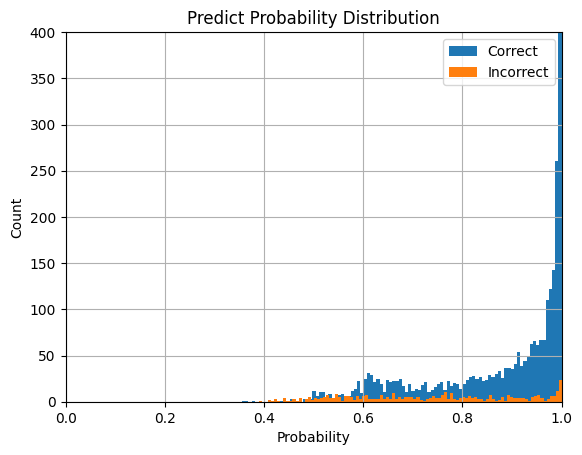

In [6]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [7]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.942761
std       0.118724
min       0.355718
max       1.000000
median    0.999733
Name: predict_probability, dtype: float64

In [8]:
thresholds = [0, 0.3, 0.35, 0.4, 0.5]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS[:len(cm)], columns=LABELS[:len(cm)])
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.950103,1.000000,0.000000,0.000000
0.30,0.950103,1.000000,0.000000,0.000000
0.35,0.950103,1.000000,0.000000,0.000000
0.40,0.950200,0.999514,0.750000,0.000486
0.50,0.953684,0.993444,0.407407,0.006556


# process to gaussian

Before standardization
std: 0.11872395563394256
--- After standardization ---
std: 1.0


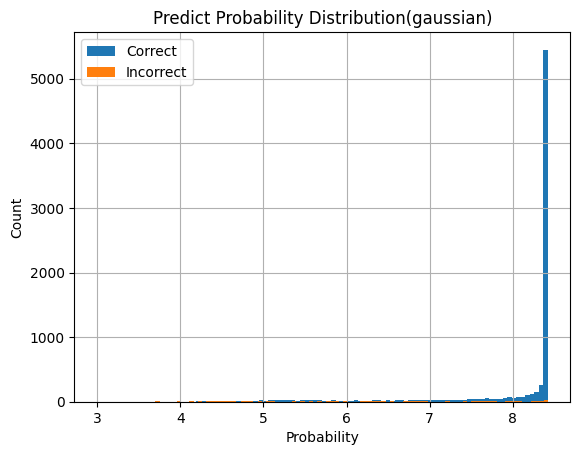

In [9]:
print("Before standardization")
std = df["predict_probability"].std()
print(f"std: {std}")
df["predict_probability_gaussian"] = df["predict_probability"].apply(lambda x: x / std)
print("--- After standardization ---")
std = df["predict_probability_gaussian"].std()
print(f"std: {std}")
df.loc[df.true_label==df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
plt.title('Predict Probability Distribution(gaussian)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [10]:
thresholds = [0, 6, 8,  9, 10]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_gaussian'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0,0.950103,1.000000,0.000000,0.000000
6,0.970420,0.915260,0.730659,0.084740
8,0.990202,0.768241,0.817182,0.231759
9,0.000000,0.000000,0.950103,1.000000
10,0.000000,0.000000,0.950103,1.000000


# process to torncurve

## 1 - (1 - x) ** 2

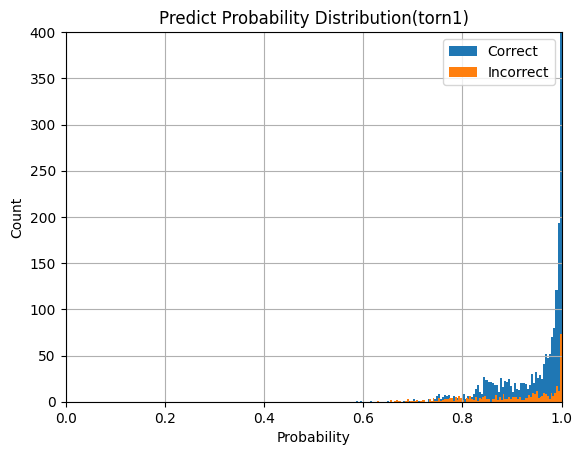

In [11]:
torn1_function = lambda x: 1-(1-x)**2
df["predict_probability_torn1"] = df["predict_probability"].apply(torn1_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn1'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn1'].hist(bins=100)
plt.title('Predict Probability Distribution(torn1)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [12]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn1'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)
/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.950103,1.000000,0.000000,0.000000
0.5,0.950103,1.000000,0.000000,0.000000
0.6,0.950091,0.999757,1.000000,0.000243
0.7,0.951564,0.997572,0.350000,0.002428
0.8,0.958308,0.981304,0.519481,0.018696


## 1/ln(2) * ln(1+x)

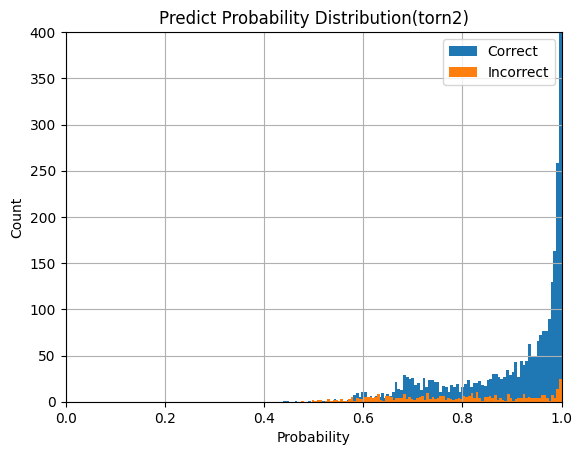

In [13]:
torn2_function = lambda x: (1/np.log(2))*np.log(1+x)
df["predict_probability_torn2"] = df["predict_probability"].apply(torn2_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn2'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn2'].hist(bins=100)
plt.title('Predict Probability Distribution(torn2)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [14]:
thresholds = [0, 0.5, 0.55, 0.6, 0.65]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn2'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_9564/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.950103,1.000000,0.000000,0.000000
0.50,0.950425,0.999150,0.571429,0.000850
0.55,0.952004,0.996601,0.392857,0.003399
0.60,0.954735,0.989681,0.505882,0.010319
0.65,0.959404,0.977905,0.538462,0.022095


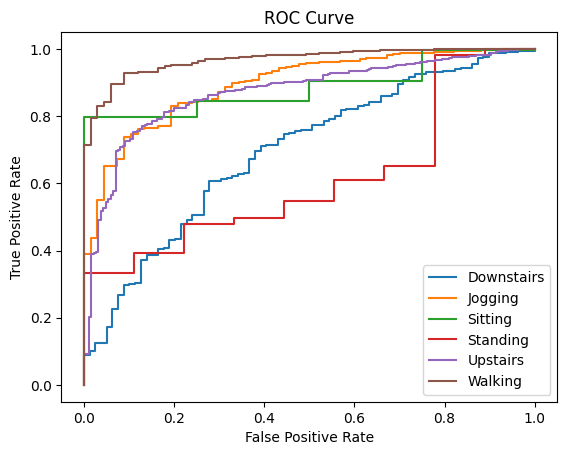

In [15]:
from sklearn.metrics import roc_curve

LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()